In [1]:
import numpy as np
import time
import math
import modules as md
#import nbodysolver as nbs
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


#------------------------------------------------------------------------------------------
#Units and conversions:
#------------------------------------------------------------------------------------------
#code units: Rsun, Msun, G=1, ...
c_SI       = 299792458.0        #m/s
M_sun_SI   = 1.989*(10.**30.)   #kg
R_sun_SI   = 695800000.         #m
R_bull_SI = 1000 #m 
AU_SI      = 149597871000.      #m 
G_new_SI   = 6.67*(10.**(-11.)) #m**3 kg**(-1) s**(-2)
AU_U       = AU_SI/R_sun_SI                             #from dist AU to code units (U)
kmsec_U    = 1000./np.sqrt(G_new_SI*M_sun_SI/R_bull_SI)  #from vel km/sec to code units (U)
time_U     = 1/np.sqrt(G_new_SI*M_sun_SI/R_bull_SI**3) #from CU to second np.sqrt((R_bull_SI)/(G_new_SI*M_sun_SI)) #from code units(U) to time sec
#Rsch_1Msun_unitRsun = ((2.*G_new_SI*(1.*M_sun_SI))/(c_SI**2.))/R_sun_SI
c_CU = c_SI/1000*kmsec_U

# Newtonian 

In [2]:
#Acceleration

def acc(r,m): #r position, m mass
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = (rrel**2).sum()**(1./2) 
                a[i] += -(rrel)*m[j]/(rn**3.0) #Acceleration at each time step 
    return a # return acceleration


def Jerk(r,v,m): #position, velocity, mass
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = (rrel**2).sum()**(1./2) # dot product
                vn = (vrel**2).sum()**(1./2)
                rvd = ((rrel)*(vrel)).sum()
                Je[i] += - m[j]*((vrel)/rn**3.0 - 3.*(rvd*rrel/(rn**5.0))) 
    return Je;

# Spin 

In [3]:
def accspin(r,m,ns,S):#r,m,S,ns #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = rrel/rn
                Sn = ((S[i]*S[i]).sum())**(1./2)
                a[i] += -(3./2)*ns[i]*(m[j]*Sn**2/m[i])*(runi)/(rn**4.0) #Acceleration at each time step
                
    return a # return acceleration

def Jerkspin(r,v,m, ns,S):#r,v,m,S,ns #r position, v velocity, m mass, m mass of the star, ne
    Je = np.zeros((len(r),3)) #Define the Jerk
    Je1 = np.zeros((len(r),3))
    Je2 = np.zeros((len(r),3))
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = (r[i]-r[j])
                vrel = (v[i]-v[j])
                rn = ((rrel**2).sum())**(1./2) # dot product
                Sn = ((S[i]*S[i]).sum())**(1./2)
                #Je1[i] += - (3./2)*ns[i]*((m[j])/m[i])*(2*((S*b).sum())*rrel/r**5 ) #Still need to define b 
                Je2[i] += - (3./2)*ns[i]*((m[j])/m[i])*(Sn**2)*(vrel/rn**5.0 - 5.*((vrel*rrel).sum())*(rrel)/(rn**7.0))               
                Je[i] += Je2[i] #Je1[i] + Je2[i] 
    return Je;

def bccspin(r,v,m,ns,S,I): #r position, m mass, s spin, m mass of the star
    b = np.zeros((len(r),3)) #Create acceleration vector
    b1 = np.zeros((len(r),3))
    b2 = np.zeros((len(r),3))
    #bden = np.zeros((len(r),3))
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                if(ns[i] == 0.0):
                    b[i] = np.array([0,0,0])
                elif (ns[i] != 0):
                    rrel = r[i]-r[j]
                    rn = ((rrel**2).sum())*(1./2)
                    runi = 1.*rrel/rn
                    vrel = v[i] - v[j]
                    rdv = (rrel*vrel).sum()
                    Sn = ((S[i]*S[i]).sum())**(1./2)
                    #bden[i] = I[i] #(I[i] + m[j]*ns[i]/rn**3)
                    acorr =  m[j]*ns[i]/rn**3                    
                    b1[i] += (1/(I[i]+acorr))*(3*ns[i]*m[j]*rdv*S[i])*(1/(rn**5.0))
                    #b2[i] += 
                    b[i] = b1[i] #b1[i] #+ b2[i]
    return b # return acceleration

# PN 

In [4]:
#PN Acceleration
def accPN(r,v,m): #r position, m mass, s spin, m mass of secondary
    a = np.zeros((len(r),3)) #Create acceleration vector
    a1 = np.zeros((len(r),3)) #Create acceleration vector
    a2 = np.zeros((len(r),3)) #Create acceleration vector

    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle           
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = 1.*rrel/rn
                #rvd = ((rrel)*(vrel)).sum()
                ruvd = ((runi)*(vrel)).sum()
                v2d = (vrel**2).sum()
                a1[i] += +(4./5)*(1./c_CU**5)*(m[i]*m[j]/(rn**3))*((2*m[i]/rn - 8*m[j]/rn - v2d)*vrel)
                a2[i] += +(4./5)*(1./c_CU**5)*(m[i]*m[j]/(rn**3))*(runi*(ruvd)*(52.0*m[j]/(3*rn) - 6*m[i]/rn + 3.0*v2d))
                a[i] += a1[i] + a2[i] #a1[i] +  
    return a#, a1, a2 # return acceleration


#PN Jerk v2

def JerkPN(r,v,a,m): #position, velocity, mass
    JePNLO3 = np.zeros((len(r),3))
    JePNLO3v2 = np.zeros((len(r),3))
    JePNLO4 = np.zeros((len(r),3))
    JePNLO5 = np.zeros((len(r),3))#Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                arel = a[i]-a[j]
                rn = ((rrel**2).sum())**(1./2) #norm                                                    
                vn = ((vrel**2).sum())**(1./2) 
                runi = 1.*rrel/rn
                ruvd = (runi*vrel).sum()   
                ruad = (runi*arel).sum()                                                  
                vad = (vrel*arel).sum()
                JePNLO3[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**3))*(-(vn**2)*arel + 2*vad*vrel + 3*((ruvd*(vn**2)*vrel) + 2*( vad*ruvd + (vn**2)*ruad)*runi))                
                JePNLO4[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**4))*(3*ruvd*(vn**2)*vrel + 2*(m[i]-m[j])*arel+ 3*(vn**4)*runi - 15*(ruvd**2)*(vn**2)*runi + ((52./3)*m[j]-6*m[i])*(ruad)*runi)
                JePNLO5[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**5))*(-8*(m[i] - m[j])*(ruvd)*vrel + ((52./3)*m[j]-6*m[i])*((vn**2)*runi + ruvd*vrel - 6*((ruvd**2)*runi)))
                JePNLOt = JePNLO3 + JePNLO4 + JePNLO5 
    return JePNLOt 


In [5]:
def HermiteUpdatespinbdt(dt, r, v, m, ns, S,I): # m mass of the star
    
    aN = acc(r, m) 
    aS = accspin(r, m, ns, S)
    aPN = accPN(r, v, m)
    a = aN + aS + aPN          # current acceleration
    aNdot = Jerk(r,v,m)
    aSdot = Jerkspin(r, v, m, ns, S)
    aPNdot = JerkPN(r, v, a, m)
    adot = aNdot + aSdot + aPNdot # current jerks
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aSp = accspin(rp, m, ns, S)
    aPNp = accPN(rp, vp, m)
    ap = aNp + aSp + aPNp         # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aSdotp = Jerkspin(rp, vp, m, ns, S)
    aPNdotp = JerkPN(rp, vp, ap, m)
    adotp = aNdotp + aSdotp + aPNdotp # predicted jerks 
    
    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + dt/2*(adotp + adot)
    aNc = aN + dt/2*(aNdotp + aNdot)
    aPNc = aPN + dt/2*(aPNdotp + aPNdot)
    
    #Spin
    
    b = bccspin(r,v,m,ns,S,I) #r,v,m,S,ns,I
    Sp = S + (dt*b) #+ ()*dt/2

    bp = bccspin(rp,vp,m,ns,Sp,I)
    Sc = S + (b + bp)*dt/2
    bc = b #+ ()*dt/2 Higher order terms
       
    #Sc = S
 
    return rc,vc,Sc, bc, ac, aNc,aPNc, dtp

def Hermite4thspinbdt(pri,sec, bina, nsteps,Dt):

    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))
    S_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    b_res = np.zeros((2,3,nsteps-1))

    aN_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))
    aPN_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies

    a_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    S_res[:,:,0] = bina.S.copy()
    
    nspinv = np.array([pri.nspin, sec.nspin])
    Iv = np.array([pri.inertiam, sec.inertiam])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i], v_res[:,:,i], S_res[:,:,i], b_res[:,:,i-1] , a_res[:,:,i-1],aN_res[:,:,i-1],aPN_res[:,:,i-1], dtp[i]) = HermiteUpdatespinbdt(Dt, r_res[:,:,i-1], v_res[:,:,i-1],  m, nspinv, S_res[:,:,i-1], Iv)
        #
        time[i] = time[i-1] + Dt#
        if time[i] >= timelimit:
            break
        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(pri.radisch+sec.radisch): #This is when running an equal mass bbh
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
            break
            
    r_res = r_res[:,:,:i+1]
    v_res = v_res[:,:,:i+1]
    a_res = a_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    aPN_res = aPN_res[:,:,:i]
    b_res = b_res[:,:,:i]
    S_res = S_res[:,:,:i+1]
    dtp = dtp[:i+1]
    time = time[:i+1]

    return r_res, v_res, S_res, b_res, a_res, aN_res, aPN_res, time

In [6]:
ns = md.Particle("NS",1.2,8.89,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
bh3 = md.Particle("BH",5,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius


Sd = np.array([0.1,0.3])
omega = (Sd*(ns.mass**2))/(ns.inertiam*c_CU)
#nsspinarr = np.array([0,0,ns.sdis/3])
nsspinarr = np.array([0,0,omega[1]])

nsspin = md.Particle("NS",1.2,8.89, nsspinarr)

bh3nsspin = md.Binary(bh3,nsspin, 8*nsspin.radi,0)

In [7]:
tl = 8*bh3nsspin.periodct #Time of the simulation in [cpde units]
timelimit = tl #
dt = 0.1 # 0.0001 working better 
Nsteps = int(tl/dt)#Number of ti

r,v,S,b,a,aN,aPN, time = Hermite4thspinbdt(bh3,nsspin, bh3nsspin, Nsteps, dt)

print(b[1].T)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.89045730e-21]
 [ 0.00000000e+00  0.00000000e+00 -1.18224238e-20]
 ...
 [ 0.00000000e+00  0.00000000e+00 -3.21521519e-08]
 [ 0.00000000e+00  0.00000000e+00 -3.28248830e-08]
 [ 0.00000000e+00  0.00000000e+00 -3.35157587e-08]]


In [8]:
print(S[1])

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.01585166 0.01585166 0.01585166 ... 0.01585144 0.01585143 0.01585143]]


No handles with labels found to put in legend.


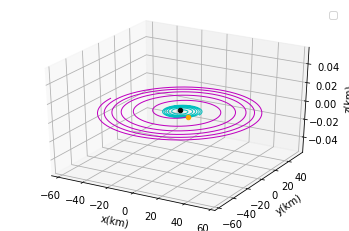

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(r[0][0], r[0][1], r[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(r[1][0], r[1][1], r[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(r[0][0][-1], r[0][1][-1], r[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(r[1][0][-1], r[1][1][-1], r[1][2][-1], 'o', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')


#plt.savefig('PNorbitaldecay.png', format='png', dpi=200)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', format='eps')#,

plt.show()

In [10]:
aratio = np.zeros_like(aN[1].T)
aPNratio = np.zeros_like(aN[1].T)

for i in range(len(aN[1].T)-1):
    aratio[i+1][0] = (a[1].T[i+1][0])/(aN[1].T[i+1][0])
    aratio[i+1][1] = (a[1].T[i+1][1])/(aN[1].T[i+1][1])
    
    aPNratio[i+1][0] = (aPN[1].T[i+1][0])/(aN[1].T[i+1][0])
    aPNratio[i+1][1] = (aPN[1].T[i+1][1])/(aN[1].T[i+1][1])
    #print(aratio[i][1])
    
#define relative position
relpos = r[1].T - r[0].T 
#define relative velocity
relvel = v[1].T - v[0].T

normrelpos = np.zeros([len(relpos), 1]) 
normrelvel = np.zeros([len(relvel), 1]) 
normS = np.zeros([len(relvel), 1]) 

for i in range(len(normrelpos)):
    normrelpos[i] = np.sqrt(relpos[i][0]**2 + relpos[i][1]**2 + relpos[i][2]**2)
    normrelvel[i] = np.sqrt(relvel[i][0]**2 + relvel[i][1]**2 + relvel[i][2]**2)
    normS[i] = np.linalg.norm(S[1].T[i])
    
print(len(normrelpos.T[0]))
print(min(normrelpos))
print(max(normrelpos))

51256
[14.30380564]
[71.12]


In [11]:
print(S[1])
print(b[1])

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.01585166 0.01585166 0.01585166 ... 0.01585144 0.01585143 0.01585143]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -5.89045730e-21 -1.18224238e-20 ... -3.21521519e-08
  -3.28248830e-08 -3.35157587e-08]]


In [12]:
print(len(normrelpos))

51256


In [13]:
n_exco = (normrelpos.T[0][1:]**2)*(2./3)*(1.*ns.mass/normS.T[0][1:]**2)*(aratio.T[0][:] - aPNratio.T[0][:] - 1) 
n_eyco = (normrelpos.T[0][1:]**2)*(2./3)*(1.*ns.mass/normS.T[0][1:]**2)*(aratio.T[1][:] - aPNratio.T[1][:] - 1)

No handles with labels found to put in legend.


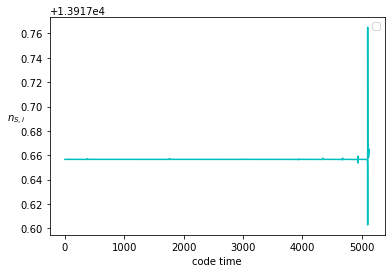

In [14]:
plt.plot(time[2:], n_exco[1:], 'c-', alpha = 1)
#plt.plot(timearrayN.T[0][2:], n_ey[1:], 'b-', label = r'$n_{Ey}$', alpha = 0.5)
#plt.plot(timearrayT[1:], posydif, 'b-', label = r'$\Delta y$', alpha = 0.8)

#plt.plot(timeave, dynstave.T[1], 'b-', label = r'$star$', alpha = 0.8)
#plt.plot(time[1:], n_e.T[2], 'g-', label = r'$n_{ez}$', alpha = 0.8)
#plt.xlim(0,30)
#plt.ylim(0.0955,0.09555)
plt.xlabel('code time')
plt.ylabel(r'$n_{S,i}$',rotation=0)

#plt.title(r'$n_{S,i}$ circular orbit')
plt.legend()
#plt.savefig('ne-evolution-circular-0.001-4rs-5orbits.eps', bbox_inches='tight')#, dpi=300

plt.show()

In [16]:
print(n_exco)

[-16103642.67365311 -16103642.66781259 -16103642.65804841 ...
   -656297.15990747   -653857.74017548   -651412.86529043]
